# Practical work 4: Frequency filtering, color

In [1]:
import numpy as np
from numpy.fft import fft2,ifft2,fftshift
import matplotlib.pyplot as plt
from PIL import Image

def imshow(I,title=None,size=500):
    """ display an image with a specific size """
    plt.figure(figsize=(size//80,size//80))
    plt.gray()
    plt.imshow(I)
    if title: plt.title(title)
    plt.show()


## Exercise 1 - Frequency filtering

1. Compute than display the centered module of Fourier transform of `img/mandrill.png` (use functions seen in previous lessons). 

In [3]:
img_mandrill = np.array(Image.open('img/mandrill.png'))

In [2]:
def computeFT(I):
    """ Array -> Array[complex] """
    return fft2(I)

def toVisualizeFT(If):
    """ Array[complex] -> Array[float] """
    return np.abs(fftshift(If))

def toVisualizeLogFT(If):
    """ Array[complex] -> Array[float] """
    return np.log(1 + np.abs(fftshift(If)))

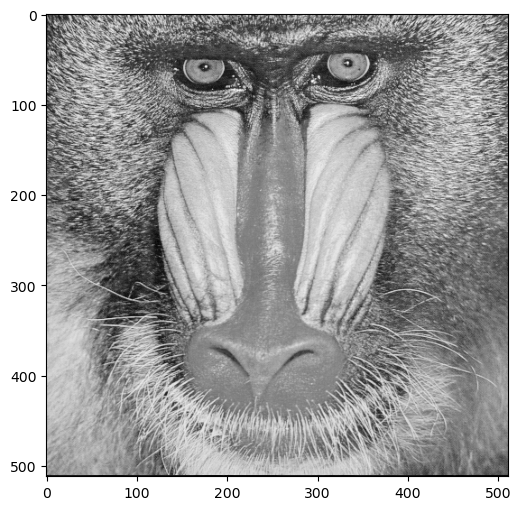

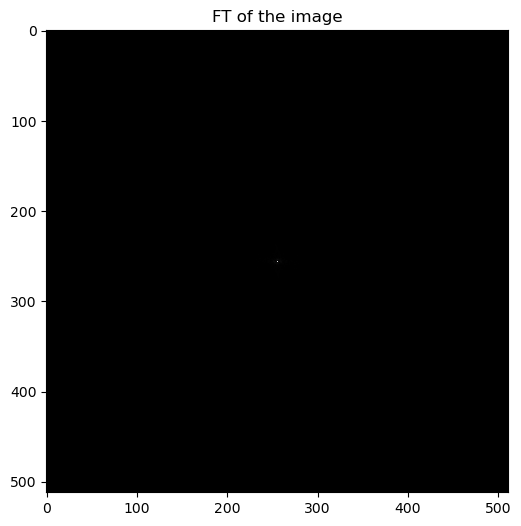

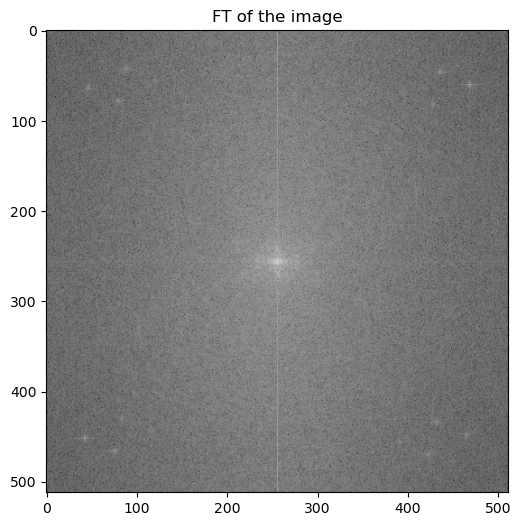

In [7]:
ft_img = computeFT(img_mandrill)
imshow(img_mandrill)
imshow(toVisualizeFT(ft_img),"FT of the image")
imshow(toVisualizeLogFT(ft_img),"FT of the image")

2. Write a function `idealLowPassFilter(n,m,fc)` returning an ideal low pass filter with frequency cutoff $f_c$ and size $n\times m$. Recall: this function set to 1 pixels at Euclidian distance $f_c$ from the center (null frequency).

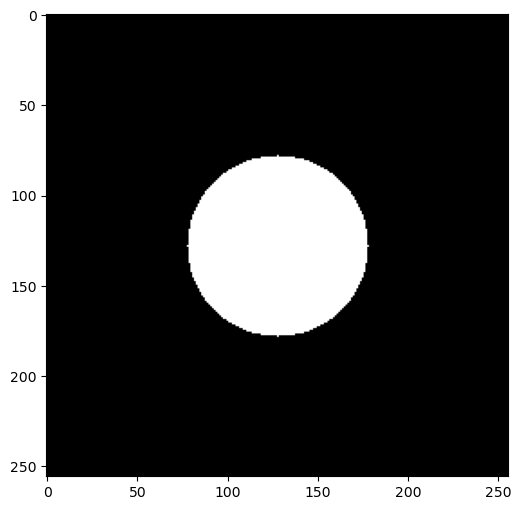

In [92]:
def idealLowPassFilter(n,m,fc):
    """ (int,int,float) -> Array[float] """
    res = np.zeros((n,m))
    for i in range(n):
        for j in range(m):
            if np.sqrt(( i - n/2 )**2 + (j - m/2 )**2 ) <= fc:
                res[i,j] = 1
    return res

imshow(idealLowPassFilter(256,256,50))

3. Write a function `lowPass(I,fc)` performing a low pass filtering of an image $I$. The function should
 - compute the centered Fourier transform of $I$
 - multiply point-by-point the spectrum with the ideal low filter produced by `idealLowPassFilter()`
 - uncenter the filtered spectrum and apply the inverse Fourier transform (use function `ifft2()` from module `numpy.fft`)
 - return the real part of filtered image

In [90]:
def lowPass(I, fc):
    # Get the dimensions of the input image
    M, N = I.shape

    # Compute the centered Fourier transform of the image
    F = computeFT(I)
    F = np.fft.fftshift(F)  # Shift the zero frequency components to the center

    # Create an ideal low-pass filter
    H = idealLowPassFilter(M, N, fc)

    # Apply the filter to the spectrum
    G = F * H

    # Uncenter the filtered spectrum
    G = np.fft.ifftshift(G)

    # Apply the inverse Fourier transform
    filtered_image = np.fft.ifft2(G)

    # Return the real part of the filtered image
    return np.real(filtered_image)

4. Experiment this function on `img/mandrill.png` and `img/lena.jpg` with various values of cut off $f_c$.
 - give two effects that appears when $f_c$ decreases,
 - propose two applications of this filtering.


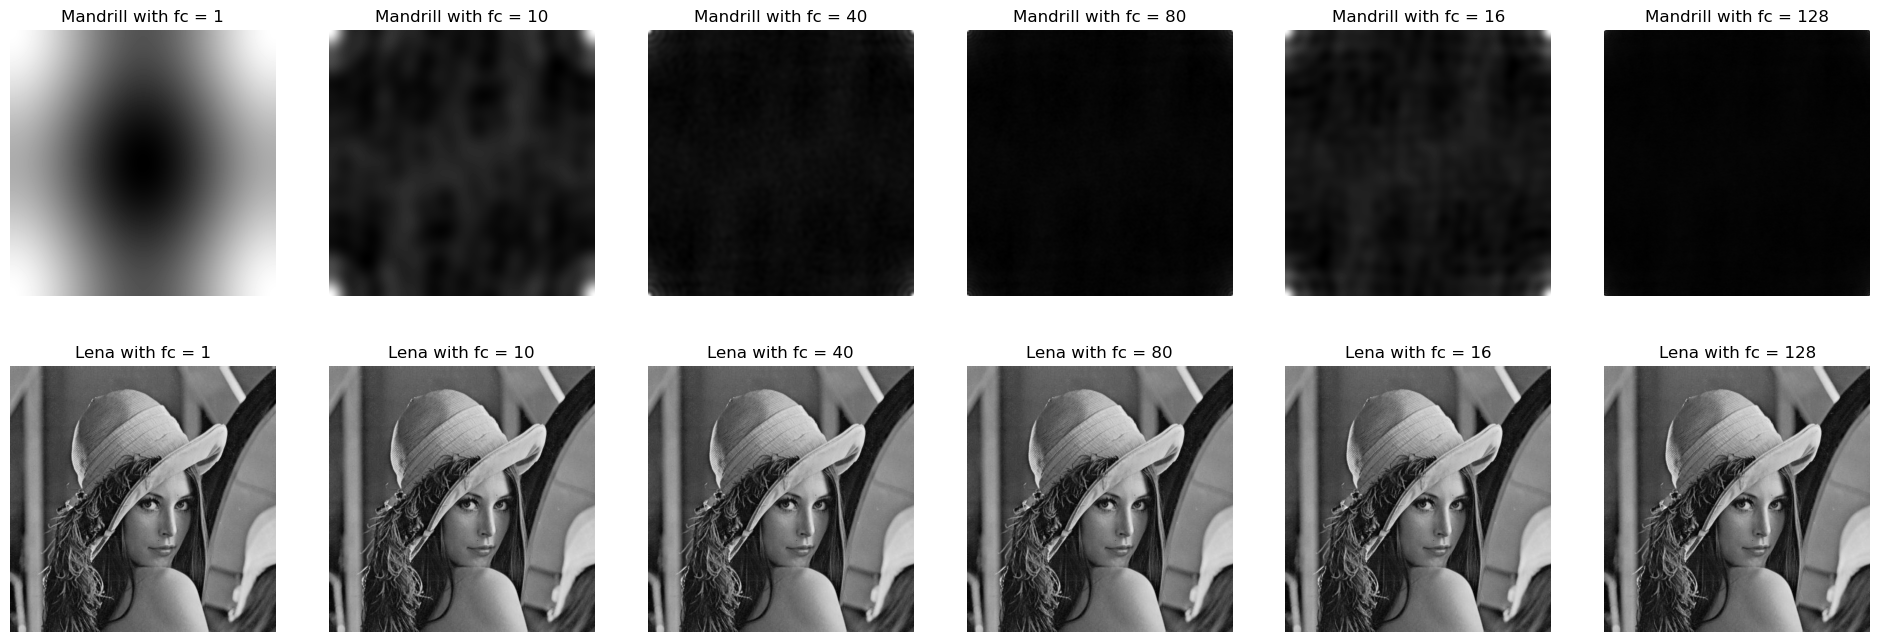

In [97]:
# Load the images
lena = np.array(Image.open("img/lena.jpg"))

fc = [1, 10, 40, 80, 16, 128]

# Create subplots
fig, axes = plt.subplots(2, len(fc), figsize=(len(fc) * 4, 8))

for i, cutoff in enumerate(fc):
    ax1 = axes[0, i]
    ax1.imshow(lowPass(img_mandrill, cutoff), cmap='gray')
    ax1.set_title(f'lowPass with fc = {cutoff}')
    ax1.axis('off')

    ax2 = axes[1, i]
    ax2.imshow(lena, cmap='gray')
    ax2.set_title(f'lowPass with fc = {cutoff}')
    ax2.axis('off')

plt.show()


# imshow(lowPass(img_mandrill, 30), "Mandrill avec lowpass idéal n=30")

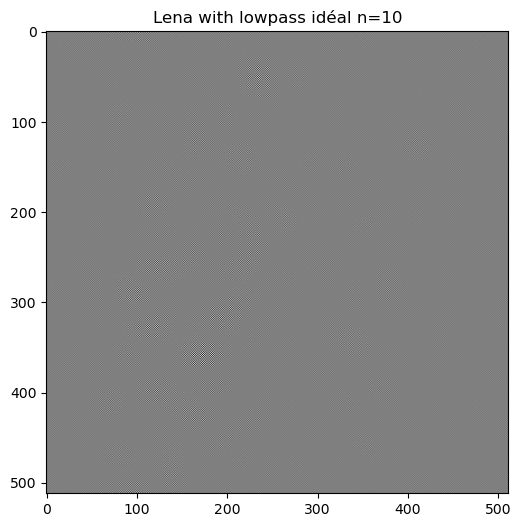

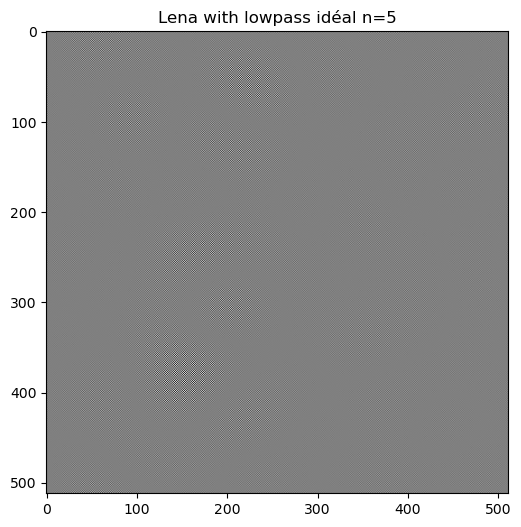

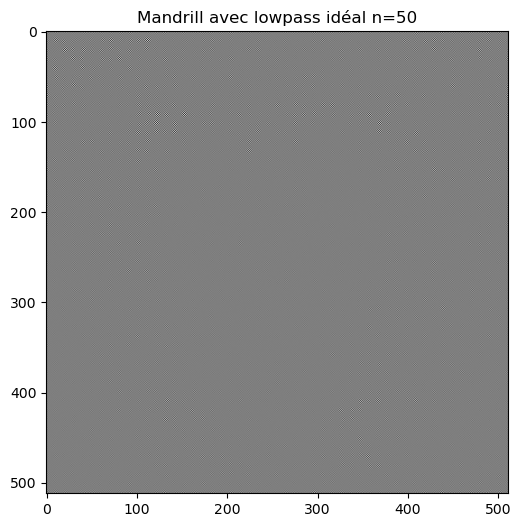

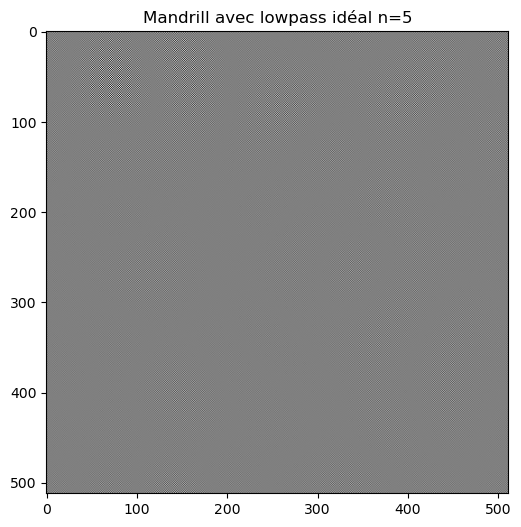

In [22]:
imshow(lowPass(lena,10),"Lena with lowpass idéal n=10")
imshow(lowPass(lena,5),"Lena with lowpass idéal n=5")
imshow(lowPass(img_mandrill,50),"Mandrill avec lowpass idéal n=50")
imshow(lowPass(img_mandrill,5),"Mandrill avec lowpass idéal n=5")

## Exercise 2 -  Linear filtering (convolution)

1. Given a kernel convolution of size $d\times d$, $d$ being odd. How many lines and columns should be added to each side of the image to apply this filter? The image is supposed surrounded by zero values.

$\frac{d-1}{2}$ rows and $\frac{d-1}{2}$ columns to each side of the image.

2. Write a function `imagePad(I,h)` getting an image and a kernel, returning a new image padded with zeros according to question 1. It is not allowed to use a module implementing the padding.

In [71]:
def imagePad(I, h):

    d = h.shape[0]

    if d % 2 == 0 :
        raise ValueError("h must be odd")

    padding = (d - 1) // 2  # Padding size for each side

    # Get the dimensions of the original image
    height, width = I.shape

    # Create a new image with zeros and padding
    padded_image = np.zeros((height + 2 * padding, width + 2 * padding), dtype=I.dtype)

    # Copy the original image into the center of the padded image
    padded_image[padding:padding + height, padding:padding + width] = I.copy()

    return padded_image


# imshow(imagePad(lena,15))
# print(imagePad(lena, 3))

3. Write a function `conv2(I,h)` getting an image and a kernel and returning the convolution of $I$ by $h$. The function should return an image having the same shape than $I$. It is not allowed to use a module implementing the convolution.

In [72]:
def conv2(I, h):
    # Get the dimensions of the input image and the kernel
    M, N = I.shape
    
    # Pad the image
    padded_image = imagePad(I, h) 
    d = h.shape[0]  # Kernel size

    # Initialize the result image
    result = np.zeros((M, N), dtype=I.dtype)

    # Perform convolution
    for i in range(M):
        for j in range(N):
            result[i, j] = np.sum(padded_image[i:i + d, j:j + d] * h)

    return result


4. Try this function on mean filter of size $3\times3$, $5\times 5$ and $7\times 7$. Discuss the results.

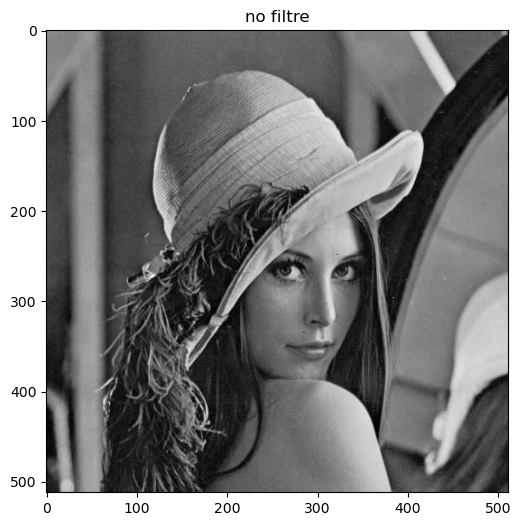

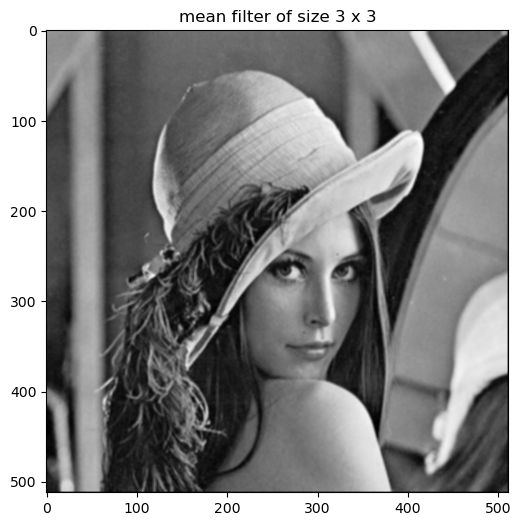

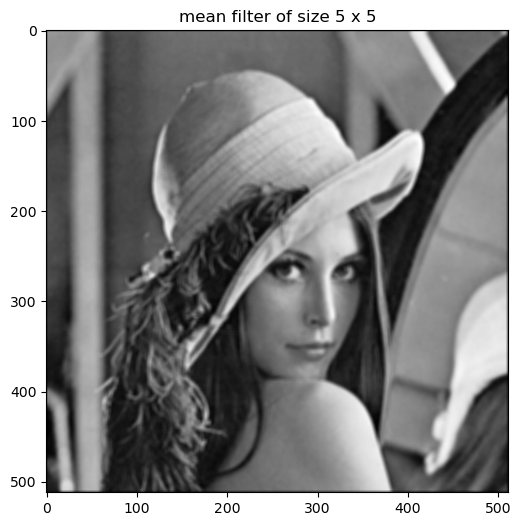

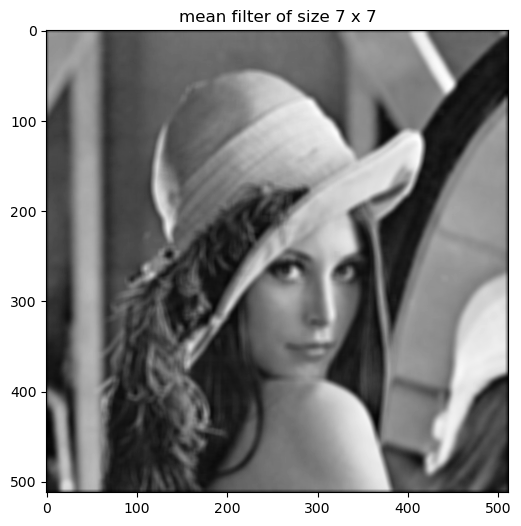

In [74]:
h_3 = (1/9) * np.ones((3, 3))
h_5 = (1/25) * np.ones((5, 5))
h_7 = (1/49) * np.ones((7, 7))

imshow(lena, "no filtre")
imshow(conv2(lena, h_3), "mean filter of size 3 x 3")
imshow(conv2(lena, h_5), "mean filter of size 5 x 5")
imshow(conv2(lena, h_7), "mean filter of size 7 x 7")

5. Display the transfert function of these mean filters. For a better visualization, use the zero-padding technique to obtain a filter with a large size (for instance $256\times 256$). Use `imshow()` and `toVisualizeLogFT()`.

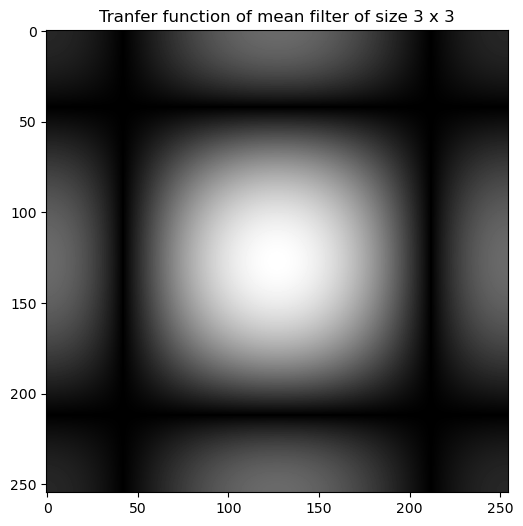

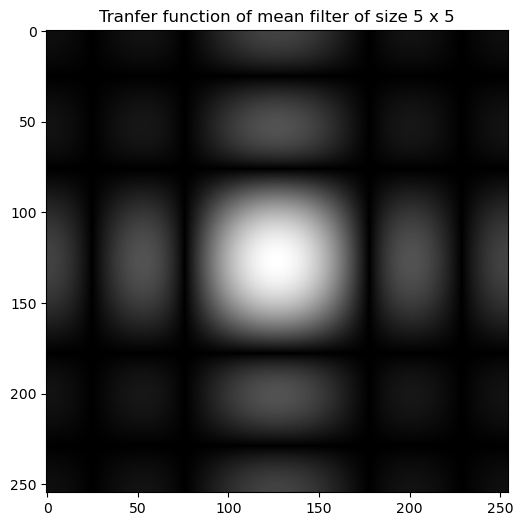

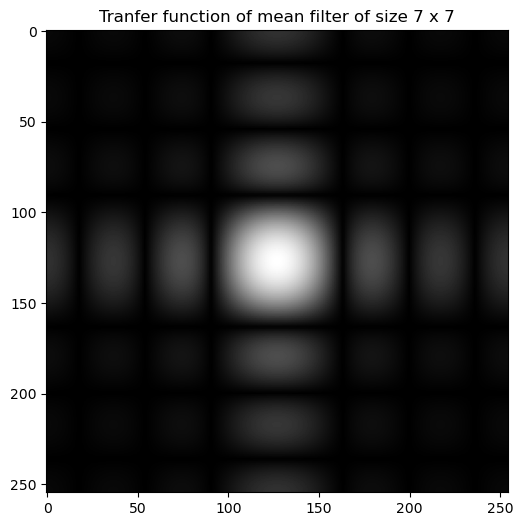

In [78]:
# Create a mean filter (e.g., 3x3)
for filter_size in range(3, 8, 2):
    mean_filter = (1 / (filter_size ** 2)) * np.ones((filter_size, filter_size))

    # Zero-padding to create a larger filter (e.g., 256x256)
    padded_filter = imagePad(mean_filter, np.zeros((256 - filter_size, 256 - filter_size)))

    # Compute the 2D Fourier Transform
    fft_result = toVisualizeLogFT(computeFT(padded_filter))
    imshow(fft_result, "Tranfer function of mean filter of size " + str(filter_size) + " x " + str(filter_size))


6. Interpretation: what is the analytic expression of the transfert function of a mean filter? Is  it an ideal low pass filter?

7. Bonus question: perform the same study for the Gaussian kernel. Determine $\sigma$ in order to have filter of size $3\times3$, $5\times5$, and $7\times7$.

In [1]:
def gaussianKernel(sigma):
    """ double -> Array
        return a gaussian kernel of standard deviation sigma
    """
    n2 = int(np.ceil(3*sigma))
    x,y = np.meshgrid(np.arange(-n2,n2+1),np.arange(-n2,n2+1))
    kern = np.exp(-(x**2+y**2)/(2*sigma*sigma))
    return  kern/kern.sum()
### your answer start below


## Exercise 3: anti aliasing filtering

1. Give a code that subsamples of factor 2 (use function `subSample2()` given in TME3) the image `img/barbara.png`.

2. Give a code that subsamples of factor 2 (use function `subSample2()`) the image `img/barbara.png` after applying an low pass filter (use `antiAliasingFilter()`). As comment, recall the principle of filtering in the frequency domain.

In [ ]:
def antiAliasingFilter(n,m):
    """ int*int -> Array """
    n2, m2 = n//2, m//2
    rn, rm = n//4, m//4
    A = np.zeros((n, m))
    A[rn:rn+n2, rm:rm+m2] = 1
    return A
### your answer start below


3. Describe and analyze the filtering of Barbara with and without the anti aliasing filter. What information is lost for the two filtered images ?

## Exercise 4: color image
1. Read images `img/clown.bmp` and `img/clown_lumi.bmp` as two arrays named $I_1$ and $I_2$. Display these images and examine their shape. What difference there are between them?

2. The first image is an array of dimension 3. Explain the signification of each dimension. From this image create 3 images $I_R$, $I_G$, $I_B$ of dimension 2. Display these three images and explain what you see.

3. Create a new image $I_3$ of dimensions 3, the first dimension contains the value of $I_R$, the second the value of $I_B$ and the third the values of $I_G$. Try another combinations. Remark: color images are better handled by `imshow()` if pixel values range in $[0,1]$.

4. Write a code that allows the see the first channel with red color scales, the second channel in green color scales, and the blue channel in blue color scales.